In [1]:
! rostopic list | grep camera_info

/camera/aligned_depth_to_color/camera_info
/camera/color/camera_info
/camera/depth/camera_info
/camera/infra1/camera_info
/camera/infra2/camera_info


Note that we're publishing our new aligned camera information to `/camera/color/camera_info` using the nodelet for `depth_image_proc/register`.

In [2]:
! rostopic echo /camera/color/camera_info | head -n 30

header: 
  seq: 1435
  stamp: 
    secs: 281
    nsecs: 927000000
  frame_id: "camera_color_optical_frame"
height: 480
width: 640
distortion_model: "plumb_bob"
D: []
K: [462.1379699707031, 0.0, 320.0, 0.0, 462.1379699707031, 240.0, 0.0, 0.0, 1.0]
R: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
P: [462.1379699707031, 0.0, 320.0, 0.0, 0.0, 462.1379699707031, 240.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 0
binning_y: 0
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: False
---
header: 
  seq: 1436
  stamp: 
    secs: 282
    nsecs: 121000000
  frame_id: "camera_color_optical_frame"
height: 480
width: 640


We can read the documentation to figure out the camera intrinsics information.

- http://docs.ros.org/en/noetic/api/sensor_msgs/html/msg/CameraInfo.html
- https://wiki.ros.org/image_pipeline/CameraInfo
- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:bali_3d_reconstruction_using_dlt.pdf

* `D` is the distortion parameter.
* `K` is a (3x3) row-major instrinsic camera matrix for raw (distorted) images.
* `R` is a (3x3) row-major rectification matrix (stereo cameras only).
* `P` is a (3x4) row-major projection matrix of the rectified image.

Let's write some Python code to read the the projection matrix and perform some mapping.
The projection matrix $P$ is given as follows:

$$
P = \begin{bmatrix}
f_x' & 0 & c_x' & Tx \\
0 & f_y' & c_y' & Ty \\
0 & 0 & 1 & 0
\end{bmatrix}
$$

Other links that might be useful:

- https://answers.gazebosim.org//question/26690/how-to-get-the-camera-matrix-of-a-camera-sensor-in-ignition-gazebo/

In [11]:
import numpy as np
import rospy
from sensor_msgs.msg import CameraInfo

# get a message from the topic
rospy.init_node("test_camera_info", anonymous=True)
camera_info = rospy.wait_for_message("/camera/color/camera_info", CameraInfo)

# We actually just want the projection matrix for callibration
P = np.array(camera_info.P).reshape(3, 4)
P

array([[462.13796997,   0.        , 320.        ,   0.        ],
       [  0.        , 462.13796997, 240.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ]])

Lets also get the camera extrinsics, which needs to be derived from Gazebo.

In [23]:
from gazebo_msgs.msg import ModelState
from gazebo_msgs.srv import GetModelState

# get the current state of the model
rospy.wait_for_service("/gazebo/get_model_state")
get_model_state = rospy.ServiceProxy("/gazebo/get_model_state", GetModelState)
camera_state = get_model_state("camera", "world")
camera_state

header: 
  seq: 3
  stamp: 
    secs: 2178
    nsecs: 259000000
  frame_id: "world"
pose: 
  position: 
    x: -2.0
    y: 0.0
    z: 1.0
  orientation: 
    x: 0.0
    y: 0.09983341664682815
    z: 0.0
    w: 0.9950041652780258
twist: 
  linear: 
    x: 0.0
    y: 0.0
    z: 0.0
  angular: 
    x: 0.0
    y: 0.0
    z: 0.0
success: True
status_message: "GetModelState: got properties"

Let's get the image from the camera, and try to find the pixel locations of the grid marks.
We'll avoid using the camera projection matrix, and just try to find a direct linear mapping to the world frame.

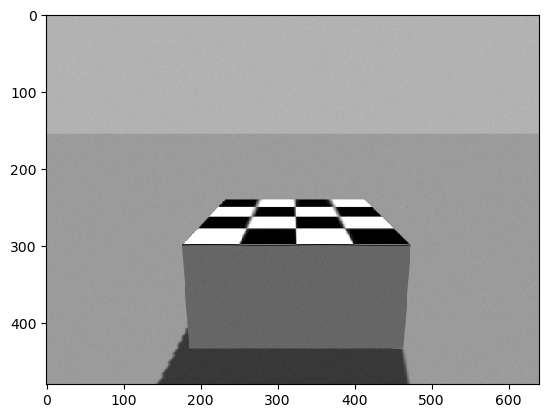

In [47]:
from cv_bridge import CvBridge
from sensor_msgs.msg import Image
import matplotlib.pyplot as plt

bridge = CvBridge()
msg = rospy.wait_for_message("/camera/color/image_raw", Image)
rgb = bridge.imgmsg_to_cv2(msg, msg.encoding)
plt.imshow(rgb)
plt.show()

Now lets try to find the position of the grid points in the image.
This might actually be more difficult than using the projection matrix with camera extrinsics, but at this way we can verify that we can obtain the results using two separate methods.

We'll use openCV to find the corners of the grid.

- https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html

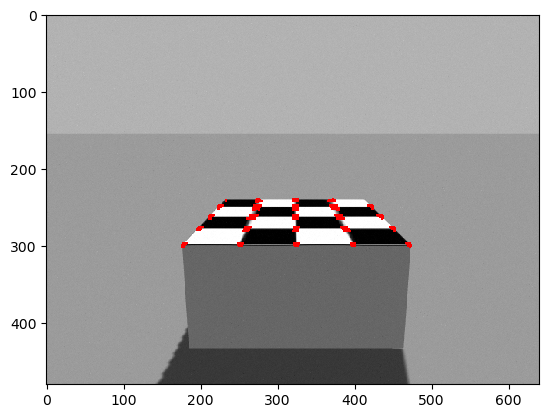

In [65]:
import cv2 as cv

img = rgb.copy()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY).astype(np.float32)

dst = cv.cornerHarris(gray, 4, 3, 0.04)
# dilate to mark the corners
dst = cv.dilate(dst, None)

img[dst > 0.01 * dst.max()] = [255, 0, 0]
plt.imshow(img)
plt.show()

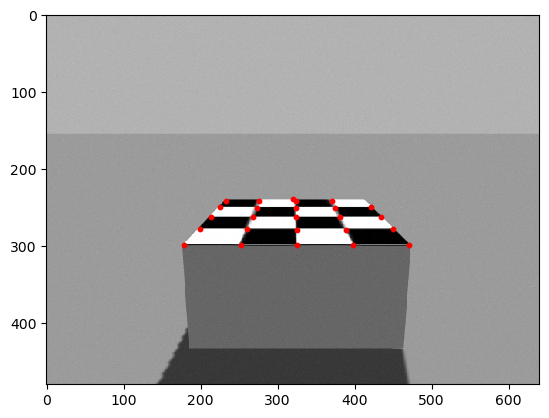

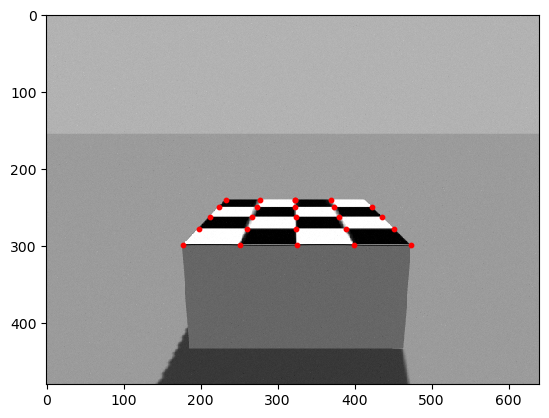

In [98]:
img = rgb.copy()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY).astype(np.float32)

dst = cv.cornerHarris(gray, 4, 3, 0.04)
dst = cv.dilate(dst, None)
ret, dst = cv.threshold(dst, 0.01 * dst.max(), 255, 0)
dst = np.uint8(dst)

ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv.cornerSubPix(
    gray, centroids.astype(np.float32), (5, 5), (-1, -1), criteria
)

# plt centroids first
plt.scatter(centroids[:, 0], centroids[:, 1], c="r", s=10)
plt.imshow(img)
plt.show()

# plot subpixel
plt.scatter(corners[:, 0], corners[:, 1], c="r", s=10)
plt.imshow(img)
plt.show()